#### Random Forest / Topological Torsions / nBits = 512

## Instantiate environment

In [66]:
'''Main'''
import numpy as np
import pandas as pd
import os
from pprint import pprint
import pickle

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import plotly.express as px
import plotly.figure_factory as ff

%matplotlib inline

'''RDKit'''
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdMolDescriptors import GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect

'''Data Preparation'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algorithms'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

## Data

### Acquire data

In [67]:
current_path = os.getcwd()
print(current_path)

C:\Users\us16120\Projects\Reports\daphniamagna\notebooks


In [68]:
parent_directory = os.path.realpath('..')
print(parent_directory)

C:\Users\us16120\Projects\Reports\daphniamagna


In [69]:
file = '\\data\\Toropova_CILS_110_177.csv'
path_to_data = parent_directory + file
df = pd.read_csv(path_to_data, header = 0)

### Explore data

In [70]:
df.shape

(297, 2)

In [71]:
df.sample(5).head()

SMILES  EndPt
82   Cc1ccc(cc1)[N+]([O-])=O   4.01
61        C[C@H](O)CC(C)(C)O   1.22
296             CNC(=S)N(C)C   2.19
67     Oc1cc(c(c(c1)Cl)Cl)Cl   5.46
40       Oc1cc(c(cc1Cl)Cl)Cl   4.86

In [72]:
distinct_counter = df.apply(lambda x: len(x.unique()))
distinct_counter

SMILES    297
EndPt     221
dtype: int64

### Build training set & test set

In [73]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Calculate fingerprints

In [74]:
train_fps = []
for i in range(0, len(train)):
    m = Chem.MolFromSmiles(train.loc[i, 'SMILES'])
    # fp = MACCSkeys.GenMACCSKeys(m)
#     fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024)
#     fp = GetHashedAtomPairFingerprintAsBitVect(m, 1024)
    fp = GetHashedTopologicalTorsionFingerprintAsBitVect(m, 512)
    train_fps.append(fp)
    
test_fps = []
for i in range(0, len(test)):
    m = Chem.MolFromSmiles(test.loc[i, 'SMILES'])
    # fp = MACCSkeys.GenMACCSKeys(m)
#     fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024)
#     fp = GetHashedAtomPairFingerprintAsBitVect(m, 1024)
    fp = GetHashedTopologicalTorsionFingerprintAsBitVect(m, 512)
    test_fps.append(fp)

 ## Helper function - scikit-learn expects two-dimensional arrays.

In [75]:
def getNumpyArrays(fplist):
    nplist = []
    for fp in fplist:
        arr = np.zeros((1,), np.float32)
        DataStructs.ConvertToNumpyArray(fp, arr)
        nplist.append(arr)
    return nplist

## Convert fingerprint list to numpy ndarray

In [76]:
np_train_fps = getNumpyArrays(train_fps)
np_test_fps = getNumpyArrays(test_fps)

## X = fingerprint ndarray; y = target

In [77]:
X_train = np_train_fps
y_train = np.ravel(train[['EndPt']])
X_test = np_test_fps
y_test = np.ravel(test[['EndPt']])

print('Training Features Shape:', len(X_train))
print('Training Labels Shape:', len(y_train))
print('Testing Features Shape:', len(X_test))
print('Testing Labels Shape:', len(y_test))

Training Features Shape: 237
Training Labels Shape: 237
Testing Features Shape: 60
Testing Labels Shape: 60


### Plot endpoint distributions for training and test sets

In [78]:
# Group data together
# hist_data = [y_train, y_test ]

# group_labels = ['Train', 'Test']

# Create distplot with custom bin_size
# fig = ff.create_distplot(hist_data, group_labels, bin_size=.1)
# fig.show()

# fig.write_image("images/TrainTest.png")

## Random Forest Regression

### Instantiate the RandomForestClassifier into an object

In [79]:
rf = RandomForestRegressor(random_state = 42)

### Look at parameters used by our current forest

In [80]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Random search, cross-validation

In [81]:
from sklearn.model_selection import RandomizedSearchCV
  
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 5, 7]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [3, 5, 7],
 'min_samples_split': [3, 5, 7],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [82]:
2 * 12 * 2 * 3 * 3 * 10

4320

### Use a random grid to search for optimal hyperparameters

Random search of parameters, using 3 fold cross validation, 
search across 100 different combinations, and use all available cores

In [83]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, scoring = 'neg_mean_absolute_error', 
                              cv = 3, verbose = 2, random_state = 42,
                              n_jobs = -1, return_train_score = True)

### Fit the random search model

In [ ]:
# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


### Report best parameters

In [61]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 600}

In [62]:
best_grid_final = rf_random.best_estimator_

best_grid_final.fit(X_test, y_test)

testPred = best_grid_final.predict(np_test_fps)

from sklearn import metrics

MeanAbsError = metrics.mean_absolute_error(y_test, testPred)
MedianAbsError = metrics.median_absolute_error(y_test, testPred)
Rsqrd = metrics.r2_score(y_test, testPred)

print('Mean Absolute Error: {:.2f}'.format(MeanAbsError))
print('Median Absolute Error: {:.2f}'.format(MedianAbsError))
print('R^2: {:.2f}'.format(Rsqrd))

Mean Absolute Error: 0.69
Median Absolute Error: 0.54
R^2: 0.66


In [63]:
best_grid_final.fit(X_train, y_train)

trainPred = best_grid_final.predict(np_train_fps)

from sklearn import metrics

MeanAbsError = metrics.mean_absolute_error(y_train, trainPred)
MedianAbsError = metrics.median_absolute_error(y_train, trainPred)
Rsqrd = metrics.r2_score(y_train, trainPred)

print('Mean Absolute Error: {:.2f}'.format(MeanAbsError))
print('Median Absolute Error: {:.2f}'.format(MedianAbsError))
print('R^2: {:.2f}'.format(Rsqrd))

Mean Absolute Error: 0.69
Median Absolute Error: 0.51
R^2: 0.75


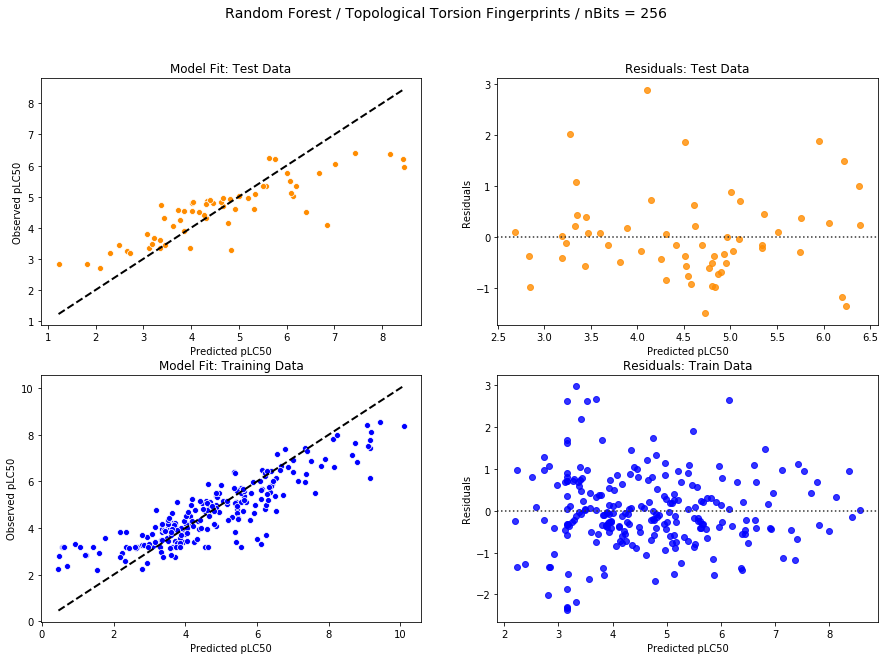

In [64]:
TRAIN = pd.DataFrame({'x': y_train, 'y': trainPred})
TEST = pd.DataFrame({'x': y_test, 'y': testPred})

train_min_true = min(y_train)
train_max_true = max(y_train)
train_min_pred = min(trainPred)
train_max_pred = max(trainPred)
train_MIN = min(train_min_true, train_min_pred)
train_MAX = max(train_max_true, train_max_pred)

test_min_true = min(y_test)
test_max_true = max(y_test)
test_min_pred = min(testPred)
test_max_pred = max(testPred)
test_MIN = min(test_min_true, test_min_pred)
test_MAX = max(test_max_true, test_max_pred)

plt.figure(figsize=(15,10))

plt.suptitle("Random Forest / Topological Torsion Fingerprints / nBits = 256", fontsize=14)

# fig.subplots_adjust(hspace=.5)
# fig.subplots_adjust(wspace=.5)

plt.subplot(2, 2, 1)
sns.scatterplot(x = 'x', y = 'y', data = TEST, color = 'darkorange')
plt.plot([test_MIN, test_MAX], [test_MIN, test_MAX], 'k--', linewidth=2)
plt.title('Model Fit: Test Data')
plt.ylabel('Observed pLC50')
plt.xlabel('Predicted pLC50')

plt.subplot(2, 2, 2)
sns.residplot(testPred, y_test, lowess=False, color="darkorange")
plt.title('Residuals: Test Data')
plt.ylabel('Residuals')
plt.xlabel('Predicted pLC50')

plt.subplot(2, 2, 3)
sns.scatterplot(x = 'x', y = 'y', data = TRAIN, color = 'blue')
plt.plot([train_MIN, train_MAX], [train_MIN, train_MAX], 'k--', linewidth=2)
plt.title('Model Fit: Training Data')
plt.ylabel('Observed pLC50')
plt.xlabel('Predicted pLC50')
                                  
plt.subplot(2, 2, 4)
sns.residplot(trainPred, y_train, lowess=False, color="blue")
plt.title('Residuals: Train Data')
plt.ylabel('Residuals')
plt.xlabel('Predicted pLC50')

# plt.savefig("images/RF_AP_1024.png")

imageFile = 'RF_TopoTorsion_256.png'
path_to_image_file = parent_directory + '\images\\' + imageFile
plt.savefig(path_to_image_file)

In [65]:
pickleFile = 'RF_TopoTorsion_256.p'
path_to_pickle_file = parent_directory + '\pickledModels\\' + pickleFile

# pickle.dump( best_grid_final, open( "pickledModels/RF_AP_1024.p", "wb" ) )
pickle.dump( best_grid_final, open( path_to_pickle_file, "wb" ) )